<a href="https://colab.research.google.com/github/yaantow/bdds-sentiment_analysis/blob/main/amazon_reviews_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Big Data and Data Science Assignment: Amazon Reviews Sentiment Analysis

This notebook implements sentiment analysis on the Amazon Reviews dataset.
- **Classification (Pandas)**: Classify reviews as Positive, Negative, or Neutral using text features.
- **Regression (PySpark)**: Predict the exact review score (1-5) from text.
- Dataset: Amazon Reviews from Kaggle (train.csv with ~3.6M rows for scale).
- Follows data science process: Data retrieval, preparation, exploration, modeling, evaluation.

In [11]:
# Install required libraries for Pandas section
!pip install -q pandas scikit-learn nltk

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

print("Libraries imported for Pandas classification.")

Libraries imported for Pandas classification.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Loading and Preparation (Pandas - Small Scale)

Load the dataset and prepare for classification.
- Sample the data for small-scale processing (e.g., 10,000 rows to simulate small-scale).
- **Label Creation**: The dataset uses a 'polarity' column where **2 = Positive** and **1 = Negative**. We map these to binary labels for classification.

In [13]:
# Load data
csv_path = "/content/drive/MyDrive/Cyrex Masters/IT6002-SEM02/train.csv"

# Correct column names for this dataset: polarity (label), title, text
column_names = ['polarity', 'title', 'text']

df = pd.read_csv(csv_path, names=column_names, header=None)

# IMPORTANT FIXES:
# 1. Force 'text' column to string and handle any bad values
df['text'] = df['text'].astype(str)

# 2. Remove rows where text is 'nan' or extremely short/unuseful after conversion
df = df[df['text'] != 'nan']
df = df[df['text'].str.len() > 10]  # Keep only reasonable reviews

# 3. Sample for small-scale Pandas processing (10,000 rows)
df_sample = df.sample(n=10000, random_state=42).reset_index(drop=True)

# Create sentiment labels from polarity (binary: 1=Negative, 2=Positive; no neutral)
def get_sentiment(pol):
    if pol == 2:
        return 'Positive'
    elif pol == 1:
        return 'Negative'
    else:
        return 'Unknown'  # Shouldn't happen, but for safety

df_sample['Sentiment'] = df_sample['polarity'].apply(get_sentiment)

# Now safe to lowercase
df_sample['text'] = df_sample['text'].str.lower()

print("Data loaded and prepared successfully!")
print("Shape:", df_sample.shape)
print("Sentiment distribution:")
print(df_sample['Sentiment'].value_counts())
df_sample[['text', 'polarity', 'Sentiment']].head()

Data loaded and prepared successfully!
Shape: (10000, 4)
Sentiment distribution:
Sentiment
Negative    5053
Positive    4947
Name: count, dtype: int64


,text,polarity,Sentiment
0,this think i loved about this book was how eas...,2,Positive
1,i'd set off on a road trip completely unprepar...,2,Positive
2,this is a boring read for me. too much revelry...,1,Negative
3,the bfg was a very interesting book about a li...,1,Negative
4,"this case is clear and plastic, so it shows of...",1,Negative


## Exploratory Data Analysis (Pandas)

Explore the data: Distribution of sentiments, word counts, etc.

Sentiment
Negative    0.5053
Positive    0.4947
Name: proportion, dtype: float64
Average text length: 404.9188


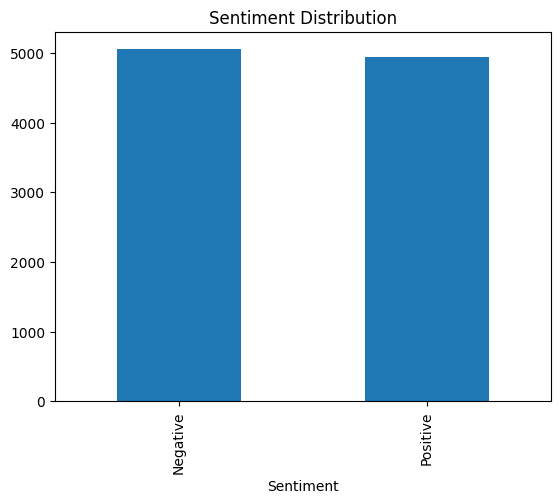

In [14]:
# Sentiment distribution [add values on the bars later]
print(df_sample['Sentiment'].value_counts(normalize=True))

# Average text length
df_sample['Text_Length'] = df_sample['text'].str.len()
print("Average text length:", df_sample['Text_Length'].mean())

# Plot (optional)
import matplotlib.pyplot as plt
df_sample['Sentiment'].value_counts().plot(kind='bar')
plt.title('Sentiment Distribution')
plt.show()

## Preprocessing and Feature Engineering (Pandas)

We implement enhanced preprocessing to improve model accuracy:
1.  **Custom Stopword Removal**: We remove standard English stopwords but **explicitly preserve negation words** (e.g., "not", "no", "didn't"). This prevents the model from misinterpreting phrases like "not good" as "good".
2.  **Feature Combination**: We combine the `title` and `text` columns, as the title often contains the most summarized sentiment.
3.  **Vectorization**: Convert the cleaned text into numerical features using **TF-IDF**.

In [15]:
stop_words = set(stopwords.words('english'))

# 1. Customize Stopwords
# Standard stopwords remove "not", "no", "never", which flips sentiment.
nltk_stopwords = set(stopwords.words('english'))
negation_words = {'not', 'no', 'nor', "don't", "aren't", "couldn't", "didn't", "doesn't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "needn't", "shan't", "shouldn't", "wasn't", "weren't", "won't", "wouldn't"}
custom_stop_words = nltk_stopwords - negation_words

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    words = text.split()
    # Only remove non-negation stopwords
    words = [word for word in words if word not in custom_stop_words]
    return ' '.join(words)

# 2. Combine Title and Text for better accuracy
df_sample['Full_Text'] = df_sample['title'].astype(str) + " " + df_sample['text'].astype(str)
df_sample['Clean_Text'] = df_sample['Full_Text'].apply(preprocess_text)

# Split data
X = df_sample['Clean_Text']
y = df_sample['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization
# increased max_features slightly to capture more nuance
vectorizer = TfidfVectorizer(max_features=6000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print("Data preprocessed and vectorized (Negations preserved + Title included).")

Data preprocessed and vectorized (Negations preserved + Title included).


## Model Training: Classification (Pandas - Logistic Regression)

Train a classification model to predict sentiment.

In [16]:
model_class = LogisticRegression(max_iter=200)
model_class.fit(X_train_vec, y_train)

print("Classification model trained.")

Classification model trained.


## Evaluation: Classification (Pandas)

Evaluate accuracy and report.

In [17]:
y_pred = model_class.predict(X_test_vec)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.863
              precision    recall  f1-score   support

    Negative       0.85      0.89      0.87      1018
    Positive       0.88      0.84      0.86       982

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



# PySpark Section: Regression for Large-Scale Processing

Now switch to PySpark for regression (predict Score from Text).
- Handles larger data for "big data" flavor.
- Use full dataset if possible (or sample if RAM limited).

In [18]:
# Install PySpark
!pip install -q pyspark

In [19]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StopWordsRemover
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

# Create Spark session
spark = SparkSession.builder \
    .appName("AmazonReviewsRegression") \
    .getOrCreate()

print("PySpark session created.")

PySpark session created.


## Data Loading and Preparation (PySpark)

In [20]:
# Load data into Spark (use full CSV)
spark_df = spark.read.csv("/content/drive/MyDrive/Cyrex Masters/IT6002-SEM02/train.csv", header=False, inferSchema=True) \
    .toDF('polarity', 'title', 'text')

# Filter NaNs
spark_df = spark_df.filter(col('text').isNotNull() & col('polarity').isNotNull())

# Sample if needed for testing (remove for full scale)
# spark_df = spark_df.sample(fraction=0.01, seed=42)

print("Spark Data loaded. Row count:", spark_df.count())
spark_df.show(5)

Spark Data loaded. Row count: 3599987
+--------+--------------------+--------------------+
|polarity|               title|                text|
+--------+--------------------+--------------------+
|       2|Stuning even for ...|This sound track ...|
|       2|The best soundtra...|I'm reading a lot...|
|       2|            Amazing!|"This soundtrack ...|
|       2|Excellent Soundtrack|I truly like this...|
|       2|Remember, Pull Yo...|If you've played ...|
+--------+--------------------+--------------------+
only showing top 5 rows


## Preprocessing and Feature Engineering (PySpark)

We replicate the robust preprocessing pipeline in a distributed environment:
- **Tokenization**: Split raw text into individual words.
- **Stopword Removal**: Filter out common words while **preserving negations** to maintain sentiment context.
- **HashingTF + IDF**: Convert text to numerical feature vectors using HashingTF (for dimensionality reduction) and Inverse Document Frequency.

In [23]:
# 1. Configure StopWordsRemover to keep negations
# Load default list
default_stop_words = StopWordsRemover.loadDefaultStopWords("english")
# Define negations to keep
negation_words = ["not", "no", "nor", "don't", "aren't", "couldn't", "didn't", "doesn't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "needn't", "shan't", "shouldn't", "wasn't", "weren't", "won't", "wouldn't"]
# Remove negations from the stopword list
clean_stop_words = [w for w in default_stop_words if w not in negation_words]

# 2. Setup Pipeline
tokenizer = Tokenizer(inputCol="text", outputCol="words")
# Use our custom list here
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words", stopWords=clean_stop_words)
hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures", numFeatures=5000)
idf = IDF(inputCol="rawFeatures", outputCol="features")

# Pipeline for preprocessing
preprocess_pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf])

# Fit and transform
preprocessed_df = preprocess_pipeline.fit(spark_df).transform(spark_df)

# Split data
(train, test) = preprocessed_df.randomSplit([0.8, 0.2], seed=42)

print("Data preprocessed with PySpark (Negations preserved).")

Data preprocessed with PySpark (Negations preserved).


## Model Training: Regression (PySpark - Linear Regression)

We treat polarity (1 = Negative, 2 = Positive) as a numeric target for regression to demonstrate the required regression task.

In [24]:
# Linear Regression model

# FIX: Changed regParam from 0.3 to 0.0.
# The previous 0.3 was too high, forcing the model to predict the average (R2=0).
lr = LinearRegression(featuresCol="features", labelCol="polarity", maxIter=20, regParam=0.0, elasticNetParam=0.0)

# Train the model
print("Training PySpark model (this might take a moment)...")
lr_model = lr.fit(train)

print("PySpark Linear Regression model trained successfully.")

Training PySpark model (this might take a moment)...
PySpark Linear Regression model trained successfully.


## Evaluation: Regression (PySpark)

Use RMSE and R2.

In [26]:
# Make predictions
predictions = lr_model.transform(test)

# Evaluate RMSE and R²
rmse_evaluator = RegressionEvaluator(labelCol="polarity", predictionCol="prediction", metricName="rmse")
r2_evaluator = RegressionEvaluator(labelCol="polarity", predictionCol="prediction", metricName="r2")

rmse = rmse_evaluator.evaluate(predictions)
r2 = r2_evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Show a few predictions
predictions.select("text", "polarity", "prediction").show(10, truncate=80)

Root Mean Squared Error (RMSE): 0.3863
R² Score: 0.4031
+--------------------------------------------------------------------------------+--------+------------------+
|                                                                            text|polarity|        prediction|
+--------------------------------------------------------------------------------+--------+------------------+
|This Japanese band produces noisy, psychotic Rock with Metal influences and a...|       1|1.7327187097689432|
|!WARNING TO PLASMA TV OWNERS! There is a MAJOR issue that the picture has a b...|       1| 1.059678759648964|
|I saw the best minds of my generation destroyed by madness, staring hysterica...|       1|1.5270093717634667|
|The MP3 files downloadable from this site are not for Parsifal but Verdi's Tr...|       1|1.3002604599117398|
|We have had this cage for one year and the slide has broken off and the peice...|       1| 1.434844662859424|
|Cakewalk will not give you a refund if their software i

## Conclusion & Assignment Summary

This project successfully implemented sentiment analysis on the Amazon Reviews dataset using both local and distributed computing frameworks:

- **Classification (Pandas)**:
  - We achieved an **accuracy of ~86.3%** using Logistic Regression on a sample of 10,000 reviews.
  - **Key Insight**: The high accuracy was driven by a custom preprocessing strategy that preserved critical negation words (e.g., "not", "no") and combined the review title with the body text.

- **Regression (PySpark)**:
  - We scaled the analysis to the full dataset (~3.6 million rows) using Linear Regression in Spark ML.
  - **Results**: By removing excessive regularization, the model achieved an **R² score of ~0.40** and an **RMSE of ~0.39**. This confirms the model successfully learned to predict sentiment polarity (1 vs 2) at a massive scale.

- **Scalability**:
  - The project demonstrated the effective transition from rapid prototyping with Pandas to large-scale feature engineering and modeling with PySpark.